#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [1]:
#!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# Paths for data.
Ravdess = "RAVDESS/"
Crema = "CREMA-D/"
Tess = "TESS/TESS Toronto emotional speech set data/"
Savee = "SAVEE/"

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for f in ravdess_directory_list:
    if f.startswith('Actor'):
        # as their are 20 different actors in our previous directory we need to extract files for each actor.
        actor = os.listdir('Ravdess/' + f)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + f + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                       Path
0    angry  RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1     fear  RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2     fear  RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3    angry  RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4  disgust  RAVDESS/Actor_16/03-01-07-01-01-01-16.wav

In [5]:
Ravdess_df

Emotions                                       Path
0       angry  RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1        fear  RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2        fear  RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3       angry  RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4     disgust  RAVDESS/Actor_16/03-01-07-01-01-01-16.wav
...       ...                                        ...
1435    happy  RAVDESS/Actor_08/03-01-03-02-02-02-08.wav
1436    happy  RAVDESS/Actor_08/03-01-03-01-01-02-08.wav
1437     calm  RAVDESS/Actor_08/03-01-02-02-01-01-08.wav
1438     calm  RAVDESS/Actor_08/03-01-02-01-02-01-08.wav
1439  neutral  RAVDESS/Actor_08/03-01-01-01-02-02-08.wav

[1440 rows x 2 columns]

## <center>2. Crema DataFrame</center>

In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                         Path
0    angry  CREMA-D/1022_ITS_ANG_XX.wav
1    angry  CREMA-D/1037_ITS_ANG_XX.wav
2  neutral  CREMA-D/1060_ITS_NEU_XX.wav
3  neutral  CREMA-D/1075_ITS_NEU_XX.wav
4  disgust  CREMA-D/1073_IOM_DIS_XX.wav

In [7]:
Crema_df

Emotions                         Path
0       angry  CREMA-D/1022_ITS_ANG_XX.wav
1       angry  CREMA-D/1037_ITS_ANG_XX.wav
2     neutral  CREMA-D/1060_ITS_NEU_XX.wav
3     neutral  CREMA-D/1075_ITS_NEU_XX.wav
4     disgust  CREMA-D/1073_IOM_DIS_XX.wav
...       ...                          ...
7437    angry  CREMA-D/1089_WSI_ANG_XX.wav
7438    angry  CREMA-D/1025_IWW_ANG_XX.wav
7439    angry  CREMA-D/1030_IWW_ANG_XX.wav
7440    angry  CREMA-D/1019_TIE_ANG_XX.wav
7441  neutral  CREMA-D/1079_IEO_NEU_XX.wav

[7442 rows x 2 columns]

##  <center> 3. TESS dataset <center>

In [8]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    if not dir.startswith('.'):
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  TESS/TESS Toronto emotional speech set data/YA...
1  disgust  TESS/TESS Toronto emotional speech set data/YA...
2  disgust  TESS/TESS Toronto emotional speech set data/YA...
3  disgust  TESS/TESS Toronto emotional speech set data/YA...
4  disgust  TESS/TESS Toronto emotional speech set data/YA...

In [9]:
Tess_df

Emotions                                               Path
0     disgust  TESS/TESS Toronto emotional speech set data/YA...
1     disgust  TESS/TESS Toronto emotional speech set data/YA...
2     disgust  TESS/TESS Toronto emotional speech set data/YA...
3     disgust  TESS/TESS Toronto emotional speech set data/YA...
4     disgust  TESS/TESS Toronto emotional speech set data/YA...
...       ...                                                ...
2795      sad  TESS/TESS Toronto emotional speech set data/OA...
2796      sad  TESS/TESS Toronto emotional speech set data/OA...
2797      sad  TESS/TESS Toronto emotional speech set data/OA...
2798      sad  TESS/TESS Toronto emotional speech set data/OA...
2799      sad  TESS/TESS Toronto emotional speech set data/OA...

[2800 rows x 2 columns]

##  <center> 4. SAVEE dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [10]:
s = 'DC_a01'
ele = s.split('_')[1]
ele[0]

'a'

In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    if not dir.startswith('.'):
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[0]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions               Path
0  surprise  SAVEE/JK_sa01.wav
1  surprise  SAVEE/JK_sa15.wav
2   neutral   SAVEE/DC_n13.wav
3  surprise  SAVEE/DC_su09.wav
4   neutral   SAVEE/DC_n07.wav

In [12]:
Savee_df

Emotions               Path
0    surprise  SAVEE/JK_sa01.wav
1    surprise  SAVEE/JK_sa15.wav
2     neutral   SAVEE/DC_n13.wav
3    surprise  SAVEE/DC_su09.wav
4     neutral   SAVEE/DC_n07.wav
..        ...                ...
475     angry   SAVEE/JE_a01.wav
476     angry   SAVEE/JE_a15.wav
477   neutral   SAVEE/DC_n22.wav
478  surprise  SAVEE/DC_su04.wav
479  surprise  SAVEE/DC_su10.wav

[480 rows x 2 columns]

In [13]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                       Path
0    angry  RAVDESS/Actor_16/03-01-05-01-02-01-16.wav
1     fear  RAVDESS/Actor_16/03-01-06-01-02-02-16.wav
2     fear  RAVDESS/Actor_16/03-01-06-02-01-02-16.wav
3    angry  RAVDESS/Actor_16/03-01-05-02-01-01-16.wav
4  disgust  RAVDESS/Actor_16/03-01-07-01-01-01-16.wav

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

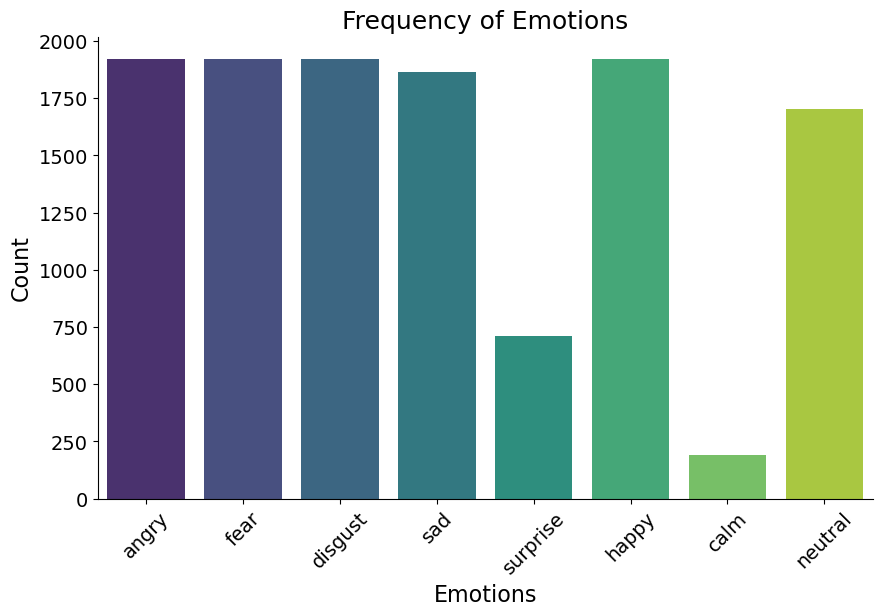

In [14]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.countplot(x=data_path.Emotions, palette="viridis")  # Ensure the bars are vertical
plt.title('Frequency of Emotions', size=18)
plt.ylabel('Count', size=16)
plt.xlabel('Emotions', size=16)
plt.yticks(size=14)
plt.xticks(rotation=45, size=14)  # Rotate labels for better readability
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

In [15]:
def create_waveshow(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    
    # Set labels and title with custom font sizes
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title(f'Waveform of Audio with {emotion.capitalize()} Emotion', fontsize=16)

def create_spectrogram(data, sr, e):
    # STFT function converts the data into short-term Fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for Audio with {} Emotion'.format(e.capitalize()), fontsize=16)  # Increased title font size
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    
    # Set axis labels with larger font size
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    
    # Increase tick label font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add colorbar and adjust its label font size
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Amplitude (dB)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.show()


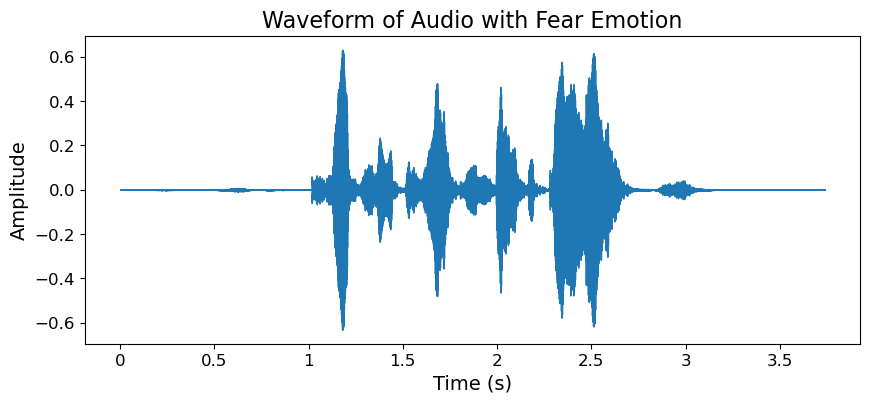

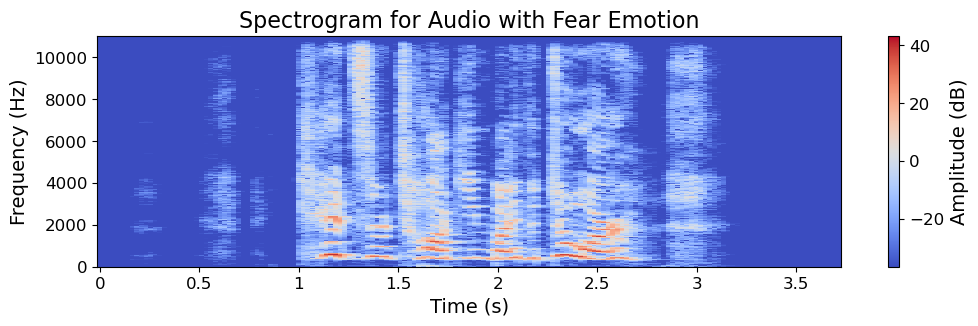

In [16]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

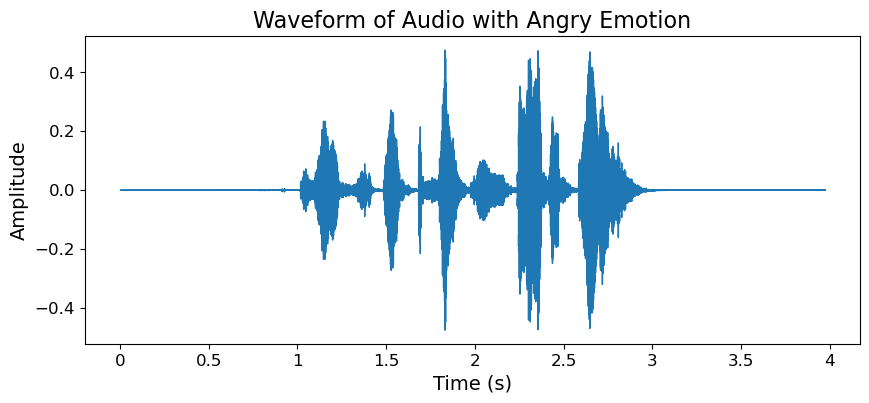

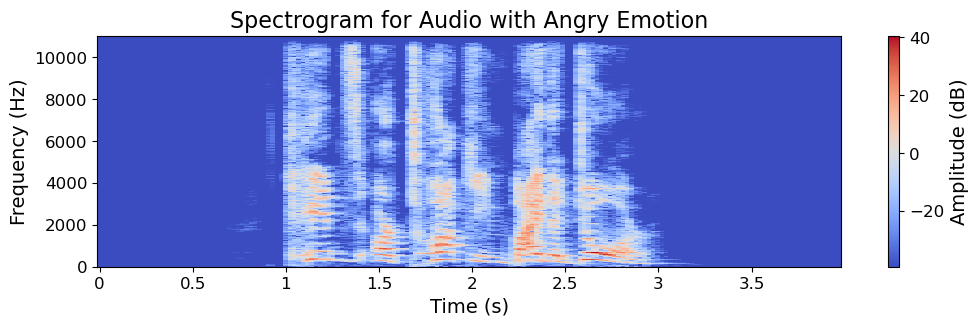

In [17]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

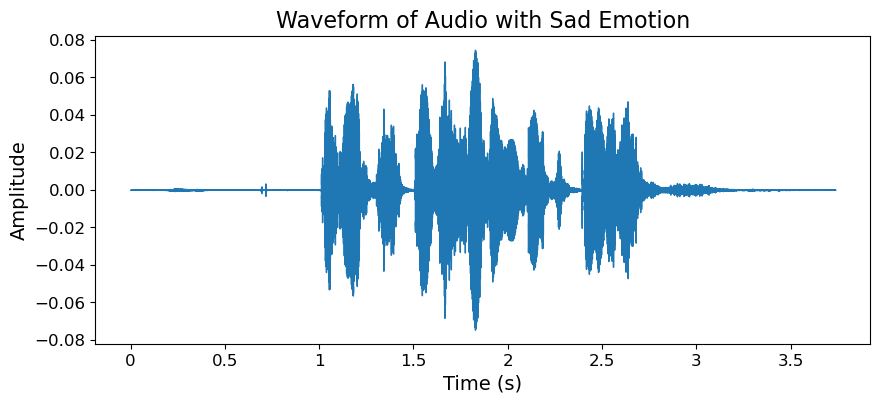

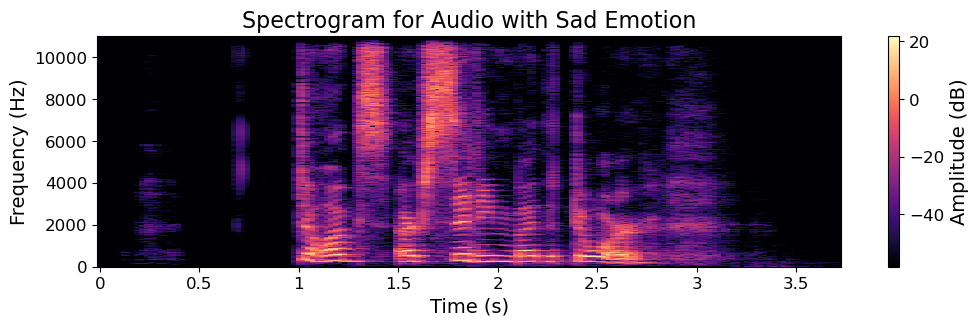

In [18]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

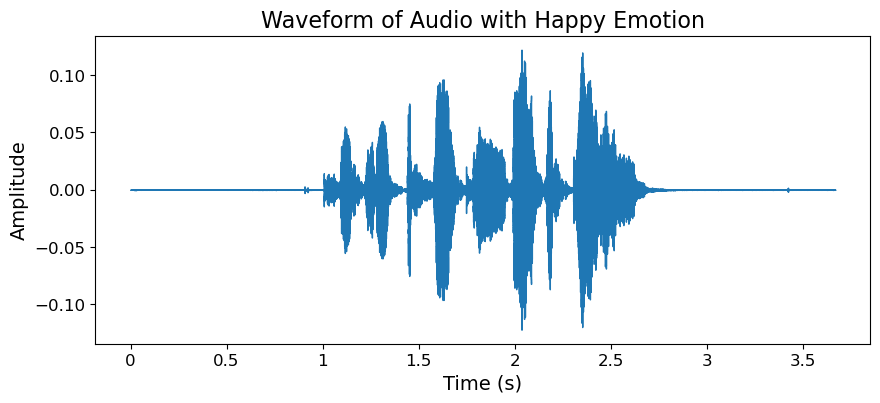

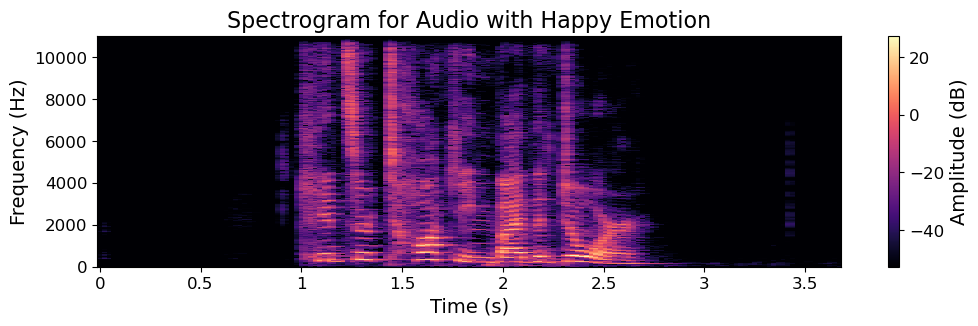

In [19]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate = 0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = 0.7)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

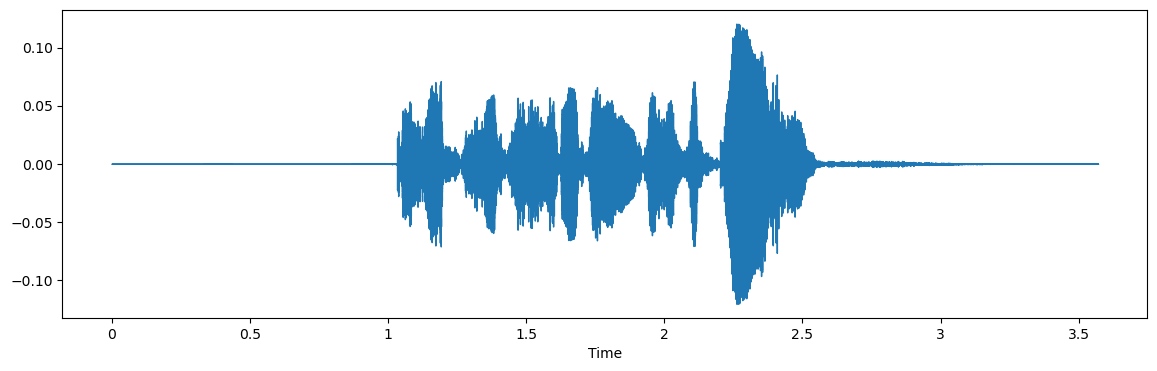

In [21]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

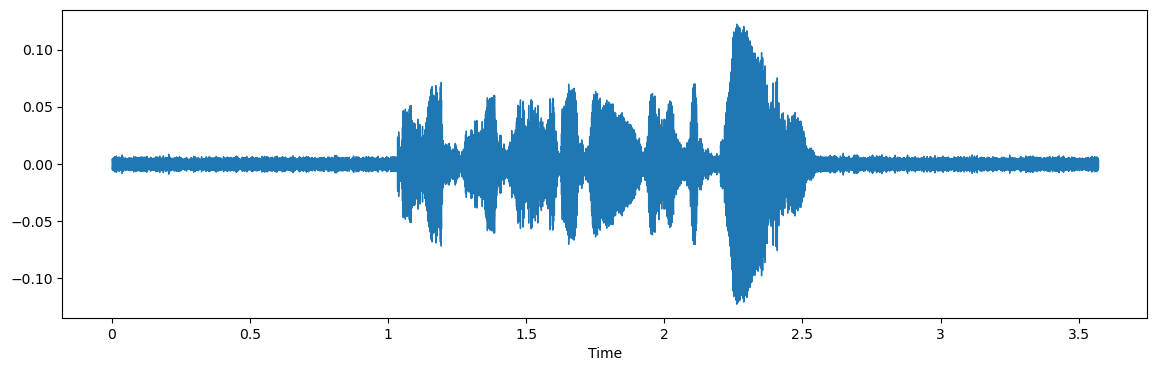

In [22]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

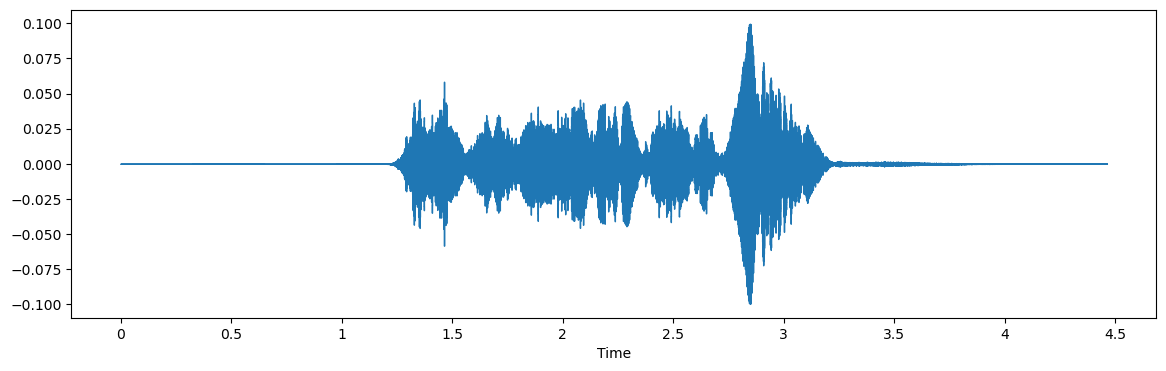

In [23]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

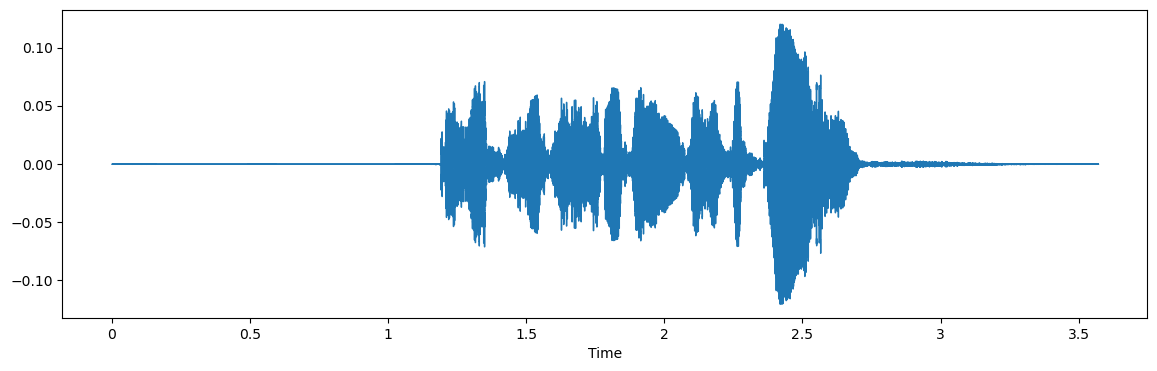

In [24]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

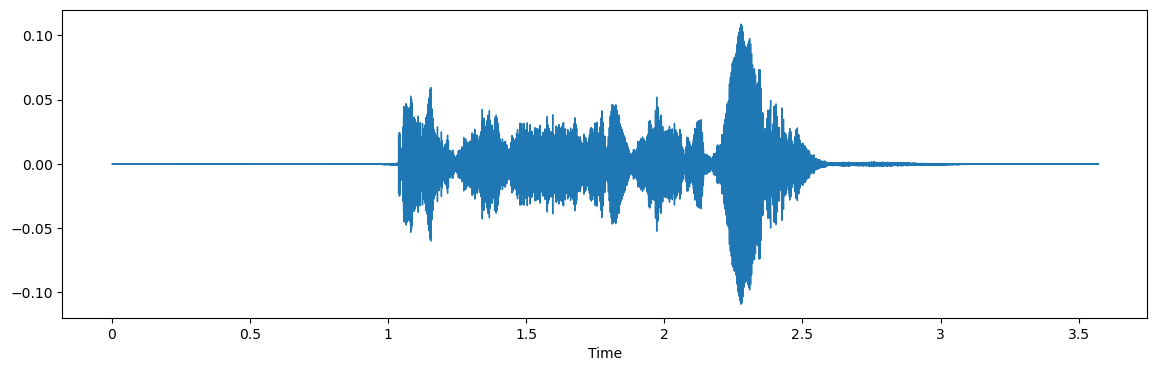

In [25]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [26]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    #Specral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [30]:
# X, Y = [], []
# for path, emotion in zip(data_path.Path, data_path.Emotions):
#     feature = get_features(path)
#     for ele in feature:
#         X.append(ele)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         Y.append(emotion)

In [31]:
# len(X), len(Y), data_path.Path.shape

In [32]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
# Features.head()

In [43]:
Features = pd.read_csv('features_8t.csv')
Features.head()

0         1         2         3         4         5         6  \
0  0.204540  0.522053  0.470343  0.491423  0.560348  0.548751  0.613287   
1  0.285843  0.592158  0.587503  0.631420  0.640571  0.654409  0.622824   
2  0.218537  0.588374  0.491138  0.457089  0.494087  0.553955  0.518942   
3  0.189815  0.559744  0.520431  0.484952  0.440133  0.394636  0.402852   
4  0.308476  0.734892  0.743416  0.729047  0.707218  0.666060  0.603570   

          7         8         9  ...        167        168       169  \
0  0.551326  0.534302  0.608861  ...  19.192859  46.253262 -0.067747   
1  0.575227  0.629543  0.721040  ...  16.947025  15.484004 -0.048863   
2  0.604753  0.512255  0.527947  ...  21.958876  50.134889 -0.034289   
3  0.411464  0.440253  0.506417  ...  20.015383  43.087176  0.005884   
4  0.562844  0.579053  0.613449  ...  14.787416  14.178436 -0.024586   

        170       171       172       173       174          175  labels  
0  0.066653 -0.049391 -0.037480 -0.011252 -0.021306  5262.375895   angry  
1  0.042722 -0.037023 -0.026324  0.000505 -0.017040  7111.140951   angry  
2  0.005860 -0.022285 -0.048962 -0.026430 -0.012038  5551.020508   angry  
3  0.029212 -0.017498  0.001927 -0.019113  0.008545  4519.978841    fear  
4  0.025951 -0.021308  0.000119 -0.007900  0.008623  7861.114502    fear  

[5 rows x 177 columns]

In [34]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [241]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [242]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 177), (27364, 8), (9122, 177), (9122, 8))

In [243]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 177), (27364, 8), (9122, 177), (9122, 8))

In [244]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 177, 1), (27364, 8), (9122, 177, 1), (9122, 8))

## Modelling

In [245]:
# Define the model architecture
model = Sequential()

# First Conv Layer
model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Second Conv Layer
model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Third Conv Layer
model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

# Fourth Conv Layer
model.add(Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Adding Bidirectional LSTM for sequential feature extraction
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Fully Connected Layers
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.3))  
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.3))  

# Output Layer
model.add(Dense(8, activation='softmax'))

# Compile the model with Adam optimizer and lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 177, 256)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 177, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 89, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 89, 512)        │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 89, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 45, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 45, 128)        │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 45, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 23, 64)         │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,656,616 (6.32 MB)

 Trainable params: 1,654,696 (6.31 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [246]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.2651 - loss: 1.8902 - val_accuracy: 0.1590 - val_loss: 2.0316 - learning_rate: 5.0000e-04
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 58s 271ms/step - accuracy: 0.4307 - loss: 1.5190 - val_accuracy: 0.3511 - val_loss: 1.8006 - learning_rate: 5.0000e-04
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 58s 271ms/step - accuracy: 0.4862 - loss: 1.3731 - val_accuracy: 0.4018 - val_loss: 1.6841 - learning_rate: 5.0000e-04
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 58s 270ms/step - accuracy: 0.5099 - loss: 1.3128 - val_accuracy: 0.3754 - val_loss: 1.6392 - learning_rate: 5.0000e-04
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 57s 265ms/step - accuracy: 0.5289 - loss: 1.2674 - val_accuracy: 0.5224 - val_loss: 1.2440 - learning_rate: 5.0000e-04
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 57s 266ms/step - accuracy: 0.5461 - loss: 1.2226 - val_accuracy: 0.4192 - val_loss: 1.4863 - learning_rate: 5.0000e-04
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 26

In [247]:
model.save('model_V5.keras')  

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6497 - loss: 1.0065
Accuracy of our model on test data :  64.22933340072632 %


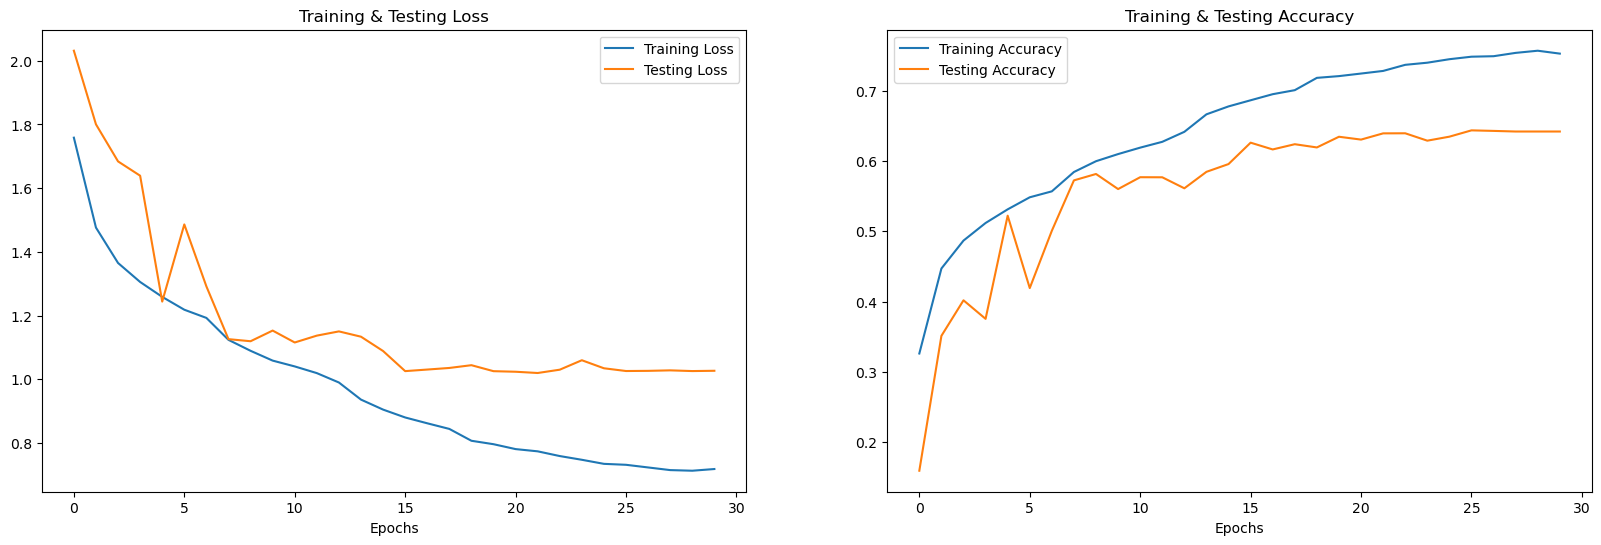

In [248]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [249]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_decoded = encoder.inverse_transform(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [250]:
#top_3_indices 
np.argsort(pred_test[0])[-3:][::-1]

pred_test[0][np.argsort(pred_test[0])[-3:][::-1]]


array([0.9901116 , 0.00523608, 0.00290214], dtype=float32)

In [251]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_decoded.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2          disgust       disgust
3            angry         angry
4              sad           sad
5            angry         happy
6             calm          calm
7              sad           sad
8              sad           sad
9         surprise      surprise

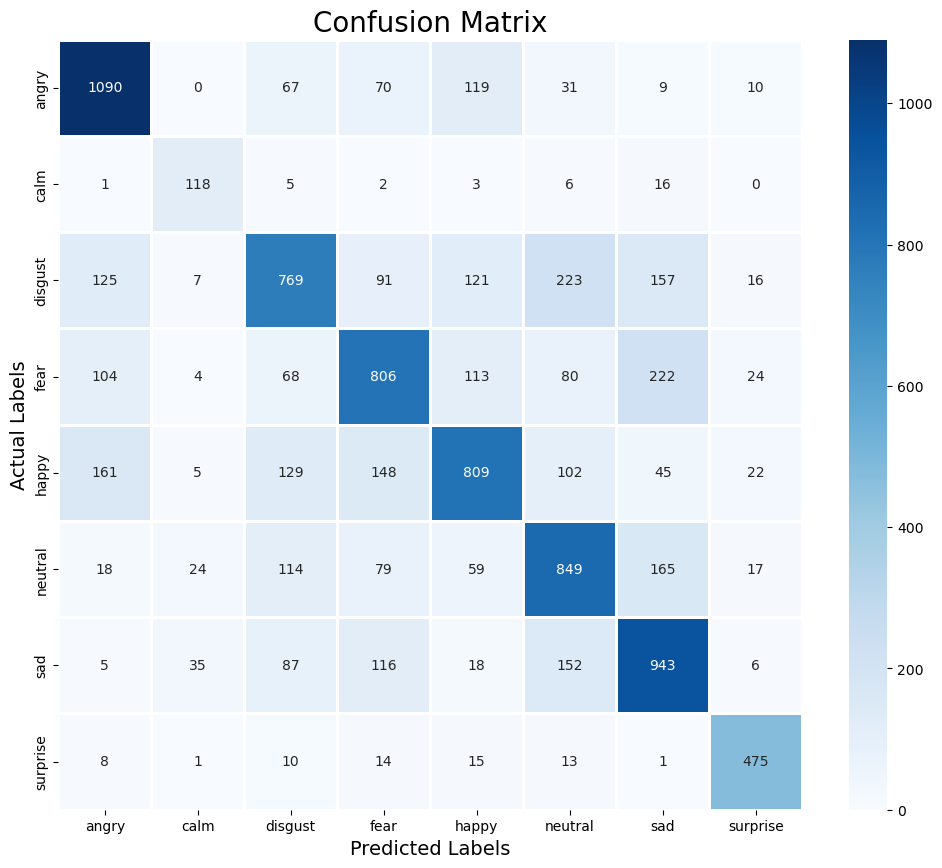

In [252]:
cm = confusion_matrix(y_test_decoded, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [253]:
print(classification_report(y_test_decoded, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.78      0.75      1396
        calm       0.61      0.78      0.68       151
     disgust       0.62      0.51      0.56      1509
        fear       0.61      0.57      0.59      1421
       happy       0.64      0.57      0.60      1421
     neutral       0.58      0.64      0.61      1325
         sad       0.61      0.69      0.65      1362
    surprise       0.83      0.88      0.86       537

    accuracy                           0.64      9122
   macro avg       0.65      0.68      0.66      9122
weighted avg       0.64      0.64      0.64      9122

